In [2]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_image_path = '/content/drive/MyDrive/image.zip'
zip_json_path = '/content/drive/MyDrive/json.zip'

image_extract_path = '/content/images_by_class'
json_extract_path = '/content/json_labels'
os.makedirs(image_extract_path, exist_ok=True)
os.makedirs(json_extract_path, exist_ok=True)

with zipfile.ZipFile(zip_image_path, 'r') as zip_ref:
    zip_ref.extractall(image_extract_path)

with zipfile.ZipFile(zip_json_path, 'r') as zip_ref:
    zip_ref.extractall(json_extract_path)

print("✅ 압축 해제 완료")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 압축 해제 완료


In [3]:
import os
import shutil

image_extract_path = '/content/images_by_class'
merged_dir = '/content/merged_images'
os.makedirs(merged_dir, exist_ok=True)

count = 0

for outer_folder in os.listdir(image_extract_path):
    outer_path = os.path.join(image_extract_path, outer_folder)
    if not os.path.isdir(outer_path):
        continue

    for class_folder in os.listdir(outer_path):
        class_path = os.path.join(outer_path, class_folder)
        if not os.path.isdir(class_path):
            continue

        class_name = class_folder.replace("TS_", "")

        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                src = os.path.join(class_path, fname)
                new_name = f"{class_name}_{fname}"
                dst = os.path.join(merged_dir, new_name)
                shutil.copy2(src, dst)
                count += 1

print(f"✅ 병합 완료: 총 {count}개의 이미지가 '{merged_dir}'에 저장되었습니다.")

✅ 병합 완료: 총 12000개의 이미지가 '/content/merged_images'에 저장되었습니다.


In [4]:
import zipfile
import os

json_zip_path = '/content/drive/MyDrive/json.zip'
json_extract_path = '/content/json_labels_full'
os.makedirs(json_extract_path, exist_ok=True)

with zipfile.ZipFile(json_zip_path, 'r') as zip_ref:
    zip_ref.extractall(json_extract_path)

print("✅ JSON 압축 해제 완료")

✅ JSON 압축 해제 완료


In [5]:
import pandas as pd
import json

merged_dir = '/content/merged_images'
json_root = '/content/json_labels_full'

records = []
class_set = set()

for fname in os.listdir(merged_dir):
    if not fname.endswith('.png'):
        continue

    try:
        identifier = '_'.join(fname.split('_')[-4:]).replace('.png', '')

        target_json = None
        for root, dirs, files in os.walk(json_root):
            for file in files:
                if file == f"{identifier}.json":
                    target_json = os.path.join(root, file)
                    break
            if target_json:
                break

        if not target_json or not os.path.exists(target_json):
            print(f"⚠ JSON 없음: {identifier}")
            continue

        with open(target_json, 'r', encoding='utf-8') as f:
            data = json.load(f)

        anno = data["annotations"][0]
        disease = anno["diagnosis_info"]["diagnosis_name"]
        class_set.add(disease)

        records.append({
            "image_path": os.path.join(merged_dir, fname),
            "class_name": disease
        })

    except Exception as e:
        print(f"❗ 오류: {fname} - {e}")

class_list = sorted(list(class_set))
class_to_idx = {name: i for i, name in enumerate(class_list)}
for r in records:
    r["label"] = class_to_idx[r["class_name"]]

df = pd.DataFrame(records)
df.to_csv("/content/skin_dataset_labeled.csv", index=False)

print(f"✅ CSV 저장 완료: {len(df)}개")
print("📋 클래스 인덱스:", class_to_idx)

✅ CSV 저장 완료: 12000개
📋 클래스 인덱스: {'광선각화증': 0, '기저세포암': 1, '멜라닌세포모반': 2, '보웬병': 3, '비립종': 4, '사마귀': 5, '악성흑색종': 6, '지루각화증': 7, '편평세포암': 8, '표피낭종': 9, '피부섬유종': 10, '피지샘증식증': 11, '혈관종': 12, '화농 육아종': 13, '흑색점': 14}


In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("/content/skin_dataset_labeled.csv")

# 75%:25% = 9,000:3,000
train_df, val_df = train_test_split(
    df, test_size=0.25, stratify=df['label'], random_state=42
)

train_df.to_csv("/content/train.csv", index=False)
val_df.to_csv("/content/val.csv", index=False)

print(f"✅ 분할 완료: Train={len(train_df)}, Val={len(val_df)}")

✅ 분할 완료: Train=9000, Val=3000


In [7]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class SkinDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.loc[idx, 'image_path']
        label = self.data.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [9]:
from torch.utils.data import DataLoader

train_dataset = SkinDataset("/content/train.csv", transform)
val_dataset = SkinDataset("/content/val.csv", transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [10]:
from torchvision import models
import torch.nn as nn
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 15)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.1MB/s]


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
for epoch in range(5):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Training Loss: {avg_loss:.4f}")

[Epoch 1] Training Loss: 0.2539
[Epoch 2] Training Loss: 0.1339
[Epoch 3] Training Loss: 0.0728
[Epoch 4] Training Loss: 0.0737
[Epoch 5] Training Loss: 0.0704


In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"✅ 검증 정확도: {accuracy:.2f}%")

✅ 검증 정확도: 98.73%


In [14]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

valimage_zip = '/content/drive/MyDrive/valimage.zip'
vallabel_zip = '/content/drive/MyDrive/vallabel.zip'

valimage_dir = '/content/test_images_raw'
vallabel_dir = '/content/test_labels_raw'
os.makedirs(valimage_dir, exist_ok=True)
os.makedirs(vallabel_dir, exist_ok=True)

with zipfile.ZipFile(valimage_zip, 'r') as zip_ref:
    zip_ref.extractall(valimage_dir)

with zipfile.ZipFile(vallabel_zip, 'r') as zip_ref:
    zip_ref.extractall(vallabel_dir)

print("✅ 이미지 및 라벨 압축 해제 완료")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ 이미지 및 라벨 압축 해제 완료


In [18]:
import os
import shutil

valimage_dir = '/content/test_images_raw/valimage'
merged_test_dir = '/content/test_images_merged'
os.makedirs(merged_test_dir, exist_ok=True)

count = 0

for outer in os.listdir(valimage_dir):
    outer_path = os.path.join(valimage_dir, outer)
    if not os.path.isdir(outer_path): continue

    class_name = outer.replace("VS_", "")

    for img_file in os.listdir(outer_path):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            src = os.path.join(outer_path, img_file)
            new_name = f"{class_name}_{img_file}"
            dst = os.path.join(merged_test_dir, new_name)
            shutil.copy2(src, dst)
            count += 1

print(f"✅ 테스트 이미지 병합 완료: 총 {count}장")

✅ 테스트 이미지 병합 완료: 총 1500장


In [19]:
import os
import json
import pandas as pd

image_dir = '/content/test_images_merged'
json_root = '/content/test_labels_raw'

records = []
class_set = set()

for fname in os.listdir(image_dir):
    if not fname.endswith('.png'):
        continue

    identifier = '_'.join(fname.split('_')[-4:]).replace('.png', '')
    target_json = None
    for root, _, files in os.walk(json_root):
        for file in files:
            if file == f"{identifier}.json":
                target_json = os.path.join(root, file)
                break
        if target_json:
            break

    if not target_json or not os.path.exists(target_json):
        print(f"⚠ JSON 없음: {identifier}")
        continue

    try:
        with open(target_json, 'r', encoding='utf-8') as f:
            data = json.load(f)
        disease = data["annotations"][0]["diagnosis_info"]["diagnosis_name"]
    except Exception as e:
        print(f"❗ JSON 파싱 실패: {fname} - {e}")
        continue

    class_set.add(disease)
    records.append({
        "image_path": os.path.join(image_dir, fname),
        "class_name": disease
    })


class_list = sorted(list(class_set))
class_to_idx = {name: i for i, name in enumerate(class_list)}
for r in records:
    r["label"] = class_to_idx[r["class_name"]]


df = pd.DataFrame(records)
df.to_csv("/content/test.csv", index=False)

print(f"✅ test.csv 생성 완료: {len(df)}개")
print("📋 클래스 인덱스:", class_to_idx)

✅ test.csv 생성 완료: 1500개
📋 클래스 인덱스: {'광선각화증': 0, '기저세포암': 1, '멜라닌세포모반': 2, '보웬병': 3, '비립종': 4, '사마귀': 5, '악성흑색종': 6, '지루각화증': 7, '편평세포암': 8, '표피낭종': 9, '피부섬유종': 10, '피지샘증식증': 11, '혈관종': 12, '화농 육아종': 13, '흑색점': 14}


In [20]:
test_dataset = SkinDataset("/content/test.csv", transform)

test_loader = DataLoader(test_dataset, batch_size=32)

In [21]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"✅ 테스트셋 정확도: {test_accuracy:.2f}%")

✅ 테스트셋 정확도: 98.80%


In [23]:

!apt-get -qq install -y fonts-nanum


import matplotlib.font_manager as fm
import matplotlib.pyplot as plt


font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

print("✅ 한글 폰트 설정 완료!")

Selecting previously unselected package fonts-nanum.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
✅ 한글 폰트 설정 완료!


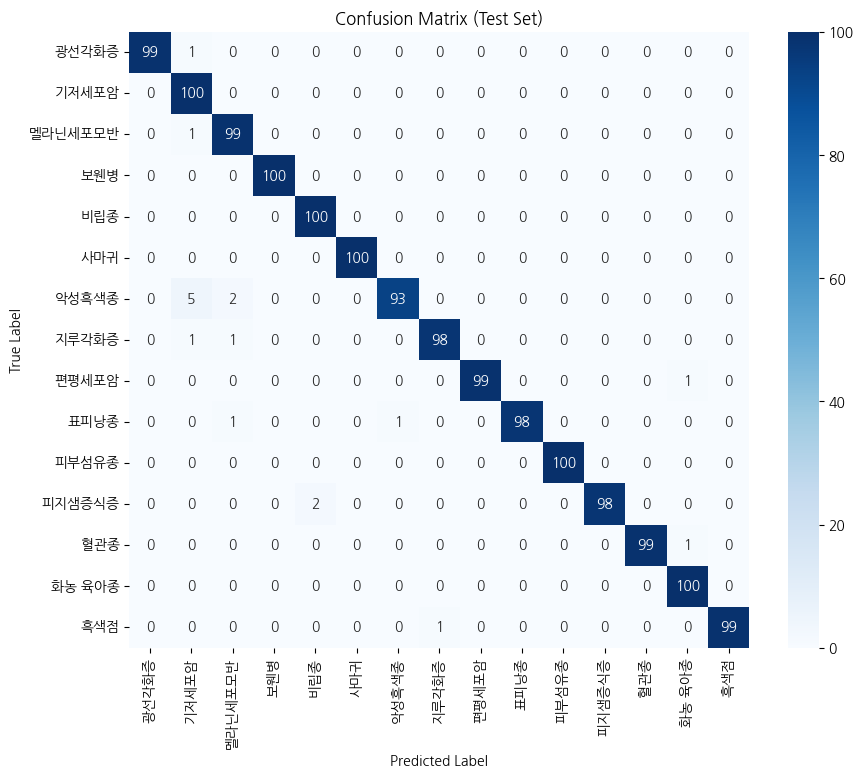

In [24]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_df = pd.read_csv("/content/test.csv")
class_names = sorted(test_df["class_name"].unique())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [25]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_preds, target_names=class_names)
print("📋 Classification Report:")
print(report)

📋 Classification Report:
              precision    recall  f1-score   support

       광선각화증       1.00      0.99      0.99       100
       기저세포암       0.93      1.00      0.96       100
     멜라닌세포모반       0.96      0.99      0.98       100
         보웬병       1.00      1.00      1.00       100
         비립종       0.98      1.00      0.99       100
         사마귀       1.00      1.00      1.00       100
       악성흑색종       0.99      0.93      0.96       100
       지루각화증       0.99      0.98      0.98       100
       편평세포암       1.00      0.99      0.99       100
        표피낭종       1.00      0.98      0.99       100
       피부섬유종       1.00      1.00      1.00       100
      피지샘증식증       1.00      0.98      0.99       100
         혈관종       1.00      0.99      0.99       100
      화농 육아종       0.98      1.00      0.99       100
         흑색점       1.00      0.99      0.99       100

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
w

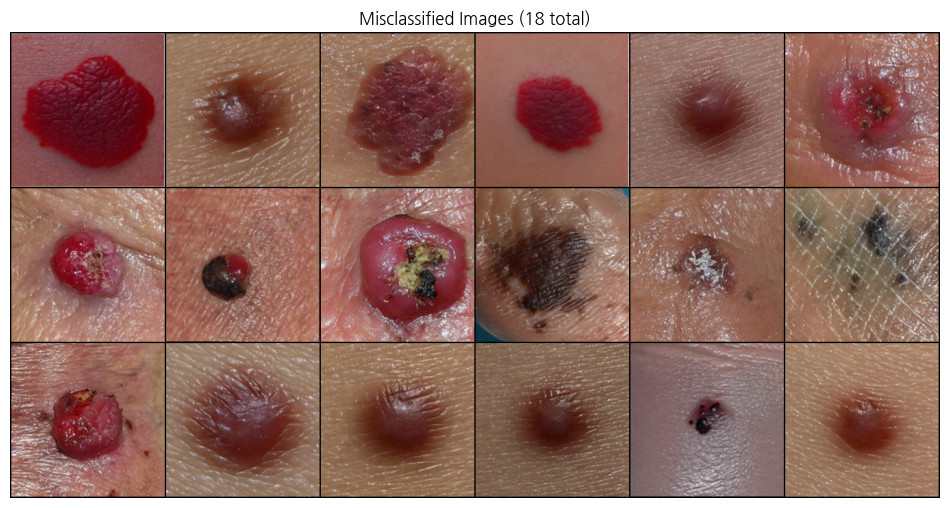

In [47]:
wrong_images = []
wrong_labels = []
wrong_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(images)):
            if predicted[i] != labels[i]:
                wrong_images.append(images[i].cpu())
                wrong_labels.append(labels[i].item())
                wrong_preds.append(predicted[i].item())
            if len(wrong_images) >= 18:
                break
        if len(wrong_images) >= 18:
            break

if wrong_images:
    grid = make_grid(wrong_images, nrow=6, normalize=True)
    plt.figure(figsize=(12, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Misclassified Images (18 total)")
    plt.axis("off")
    plt.show()

In [53]:
import os
import json
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

label_root = '/content/test_labels_raw'
merged_dir = '/content/test_images_merged'
to_pil = transforms.ToPILImage()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

idx_to_class = {v: k for k, v in class_to_idx.items()}

misclassified = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(images)):
            if preds[i] != labels[i]:
                misclassified.append({
                    'image_tensor': images[i].cpu(),
                    'true_label': labels[i].item(),
                    'pred_label': preds[i].item()
                })

print(f"✅ 오분류 수집 완료: {len(misclassified)}개")

def get_example_image_by_json(class_name, label_root, image_dir):
    for root, _, files in os.walk(label_root):
        for file in files:
            if file.endswith(".json"):
                try:
                    with open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                        data = json.load(f)
                    disease = data["annotations"][0]["diagnosis_info"]["diagnosis_name"]
                    if disease == class_name:
                        identifier = data["annotations"][0]["identifier"]
                        for img in os.listdir(image_dir):
                            if identifier in img:
                                return os.path.join(image_dir, img)
                except:
                    continue
    return None

unique_samples = {}
for sample in misclassified:
    tid = sample['image_tensor'].numpy().sum()
    if tid not in unique_samples:
        unique_samples[tid] = sample

unique_misclassified = list(unique_samples.values())[:18]

for sample in unique_misclassified:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    img_tensor = sample['image_tensor']
    true_label_name = idx_to_class[sample['true_label']]
    pred_label_name = idx_to_class[sample['pred_label']]

    axes[0].imshow(to_pil((img_tensor * 0.5 + 0.5).clamp(0, 1)))
    axes[0].set_title(f"❌ GT: {true_label_name}")
    axes[0].axis("off")

    example_img_path = get_example_image_by_json(pred_label_name, label_root, merged_dir)
    if example_img_path:
        img = Image.open(example_img_path).convert("RGB")
        axes[1].imshow(img)
        axes[1].set_title(f"Pred: {pred_label_name}")
    else:
        axes[1].text(0.5, 0.5, f"No Example\nfor {pred_label_name}", ha='center', va='center')
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [54]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
import numpy as np
import torch

target_layer = model.layer4[-1]  # ResNet18 기준 마지막 conv layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()
cam = GradCAM(model=model, target_layers=[target_layer])

unique_samples = {}
for sample in misclassified:
    tensor_id = sample['image_tensor'].numpy().sum()
    if tensor_id not in unique_samples:
        unique_samples[tensor_id] = sample

unique_misclassified = list(unique_samples.values())[:18]

def visualize_gradcam_with_original(misclassified, idx_to_class):
    for sample in misclassified:
        image_tensor = sample['image_tensor'].unsqueeze(0).to(device)
        true_label = sample['true_label']
        pred_label = sample['pred_label']

        input_img = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
        input_img = (input_img * 0.5 + 0.5).clip(0, 1).astype(np.float32)

        targets = [ClassifierOutputTarget(pred_label)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0]
        cam_image = show_cam_on_image(input_img, grayscale_cam, use_rgb=True)

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(input_img)
        axes[0].set_title(f"✅ 원본\nGT: {idx_to_class[true_label]}")
        axes[0].axis("off")

        axes[1].imshow(cam_image)
        axes[1].set_title(f"🔥 Grad-CAM\nPred: {idx_to_class[pred_label]}")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

visualize_gradcam_with_original(unique_misclassified, idx_to_class)

Output hidden; open in https://colab.research.google.com to view.

In [55]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import torch
import numpy as np
import matplotlib.pyplot as plt

target_layer = model.layer4[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()
cam = GradCAM(model=model, target_layers=[target_layer])

correct_samples = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(images)):
            if preds[i] == labels[i]:
                correct_samples.append({
                    "image_tensor": images[i].cpu(),
                    "true_label": labels[i].item(),
                    "pred_label": preds[i].item()
                })

unique_correct = {}
for sample in correct_samples:
    tensor_id = sample['image_tensor'].numpy().sum()
    if tensor_id not in unique_correct:
        unique_correct[tensor_id] = sample

unique_correct_samples = list(unique_correct.values())[:20]

for sample in unique_correct_samples:
    image_tensor = sample['image_tensor'].unsqueeze(0).to(device)
    true_label = sample['true_label']
    pred_label = sample['pred_label']

    # 복원 이미지: [-1,1] → [0,1]
    input_img = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
    input_img = (input_img * 0.5 + 0.5).clip(0, 1).astype(np.float32)

    # Grad-CAM 실행
    targets = [ClassifierOutputTarget(pred_label)]
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0]
    cam_image = show_cam_on_image(input_img, grayscale_cam, use_rgb=True)


    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(input_img)
    axes[0].set_title(f"✅ 원본\nGT: {idx_to_class[true_label]}")
    axes[0].axis("off")

    axes[1].imshow(cam_image)
    axes[1].set_title(f"🎯 Grad-CAM\nPred: {idx_to_class[pred_label]}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [28]:
train_losses = []
val_losses = []

for epoch in range(5):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1} ▶ Train Loss: {epoch_loss:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1 ▶ Train Loss: 0.0538, Val Loss: 0.0584
Epoch 2 ▶ Train Loss: 0.0331, Val Loss: 0.3821
Epoch 3 ▶ Train Loss: 0.0650, Val Loss: 0.0321
Epoch 4 ▶ Train Loss: 0.0263, Val Loss: 0.0526
Epoch 5 ▶ Train Loss: 0.0505, Val Loss: 0.1998


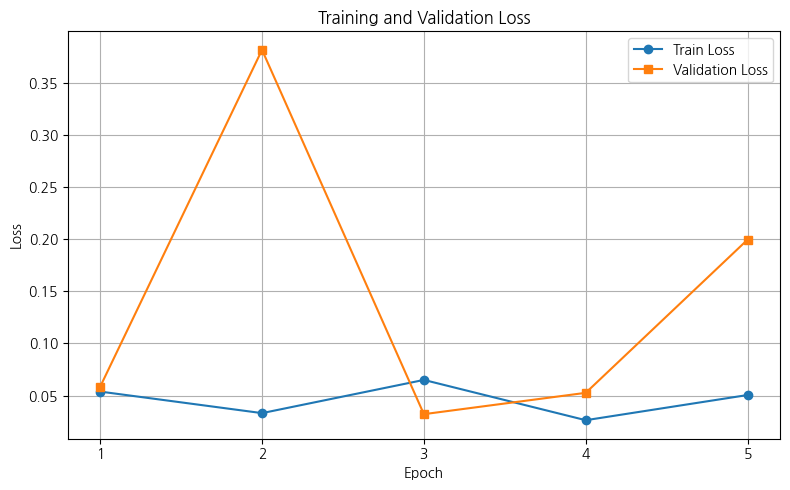

In [63]:
import matplotlib.pyplot as plt

train_losses = [0.0538, 0.0331, 0.0650, 0.0263, 0.0505]
val_losses = [0.0584, 0.3821, 0.0321, 0.0526, 0.1998]
epochs = range(1, len(train_losses) + 1)  # [1, 2, 3, 4, 5]

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

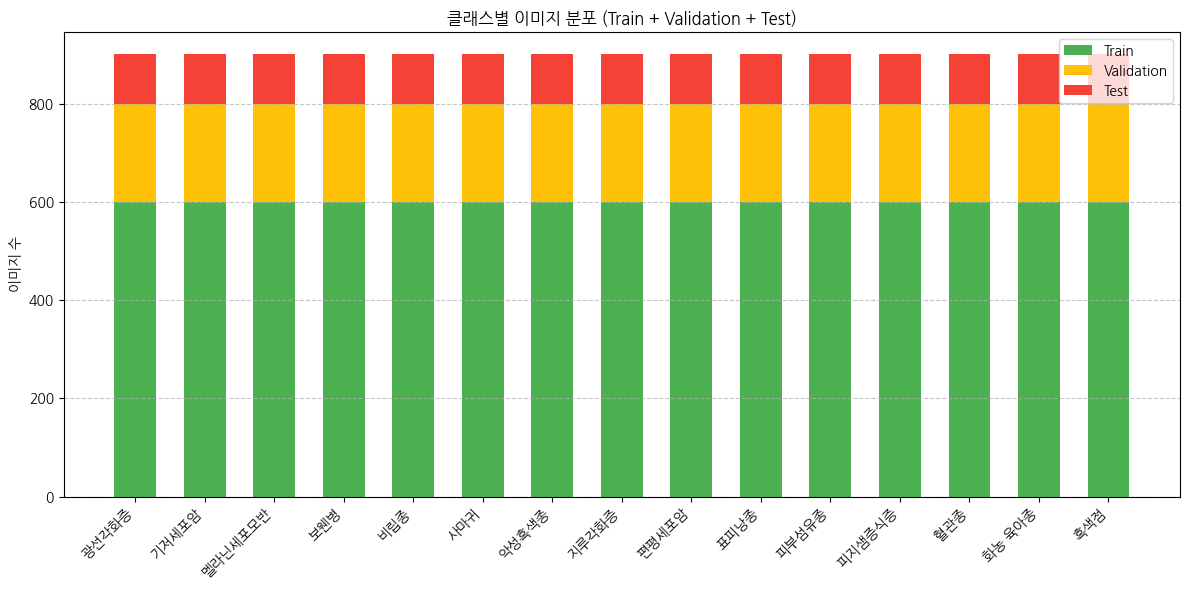

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름 (15개)
class_names = [
    '광선각화증', '기저세포암', '멜라닌세포모반', '보웬병', '비립종',
    '사마귀', '악성흑색종', '지루각화증', '편평세포암', '표피낭종',
    '피부섬유종', '피지샘증식증', '혈관종', '화농 육아종', '흑색점'
]


n_classes = len(class_names)
train_counts = [600] * n_classes
val_counts = [200] * n_classes
test_counts = [100] * n_classes
x = np.arange(n_classes)
width = 0.6


plt.figure(figsize=(12, 6))
plt.bar(x, train_counts, width, label='Train', color='#4CAF50')
plt.bar(x, val_counts, width, bottom=train_counts, label='Validation', color='#FFC107')
plt.bar(x, test_counts, width, bottom=np.array(train_counts) + np.array(val_counts), label='Test', color='#F44336')


plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylabel("이미지 수")
plt.title("클래스별 이미지 분포 (Train + Validation + Test)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()